In [1]:
import powerlaw
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Load the NYC Subway Graph

In [2]:
nyc = ig.read("../data/nyc_subway.gml")


## Degree Distribution and Scale-Free Properties of the Network

In [3]:
node_degree = np.array(nyc.degree())

We fit the empirical data to a Power Law distribution using the `powerlaw` package introduced by:

*Jeff Alstott, Ed Bullmore, Dietmar Plenz. (2014). powerlaw: a Python package for analysis of heavy-tailed distributions. PLoS ONE 9(1): e85777*

Text(0.5, 1.0, 'Log-Log Plot')

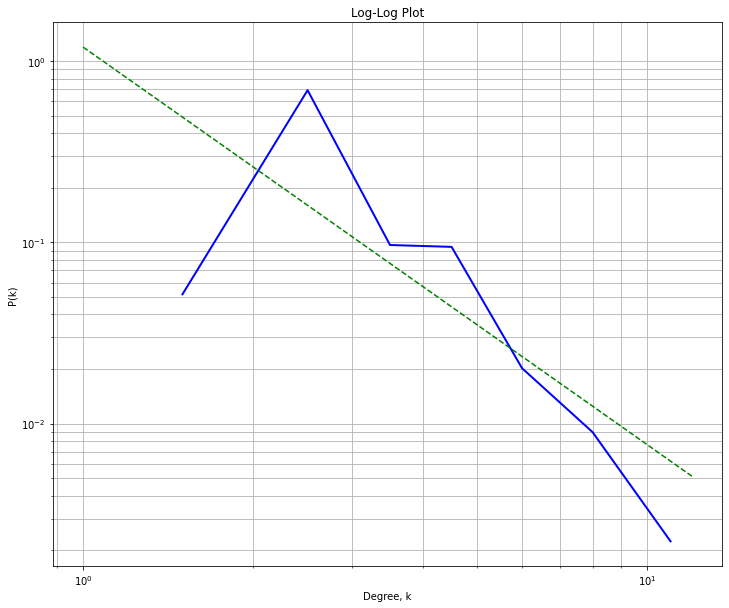

In [4]:
fit = powerlaw.Fit(node_degree, xmin=1)

f, ax = plt.subplots(figsize=(12, 10))
_ = fit.plot_pdf(color='b', linewidth=2, ax=ax)
_ = fit.power_law.plot_pdf(color='g', linestyle='--', ax=ax)

ax.grid(which="both")
ax.set_xlabel("Degree, k")
ax.set_ylabel("P(k)")
ax.set_title("Log-Log Plot")

In [5]:
def PowerLawPDF(alpha):
    def pdf(x):
        return x ** -alpha
    return pdf

In [6]:
def plot_variable(variable: np.ndarray):
    kde = gaussian_kde(variable)
    dist_space = np.linspace(min(variable), max(variable), 100)
    f, ax = plt.subplots(figsize=(12, 10))
    ax.plot(dist_space, kde(dist_space))
    return f, ax

Text(0.5, 1.0, 'Probability Density Plot')

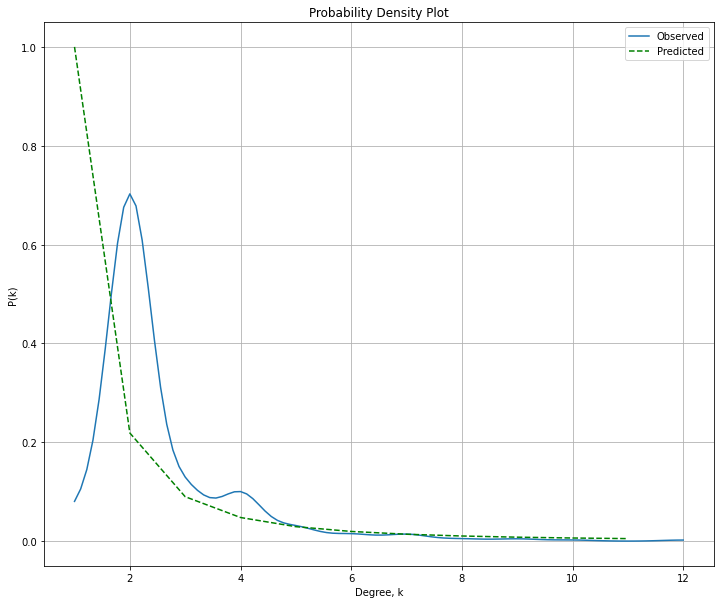

In [7]:
f, ax = plot_variable(node_degree)

pdf = PowerLawPDF(fit.alpha)
degree_range = np.array(range(min(node_degree), max(node_degree)))
probs = pdf(degree_range)
ax.plot(degree_range, probs, "g--")

ax.legend(["Observed", "Predicted"])
ax.set_ylabel("P(k)")
ax.set_xlabel("Degree, k")
ax.grid(which="both")
ax.set_title("Probability Density Plot")

Comparing the observed data with the model fitted using a power law, we can see that the degree distribution of the network does not follow a that of a scale-free network.

# Betweeness and Participation Score

To understand the importance of different nodes in the network, we follow the methodology proposed in:

*Guimera, Roger, et al. (2005). "The worldwide air transportation network: Anomalous centrality, community structure, and cities' global roles."*

Specifically we look at the relationship of node Betweeness and the Participation Score defined in the paper. To account for the difference in importance between links in the networks, we use a weighted approach by counting the number of trips between nodes.

In [8]:
node_betweeness = np.array(nyc.betweenness())

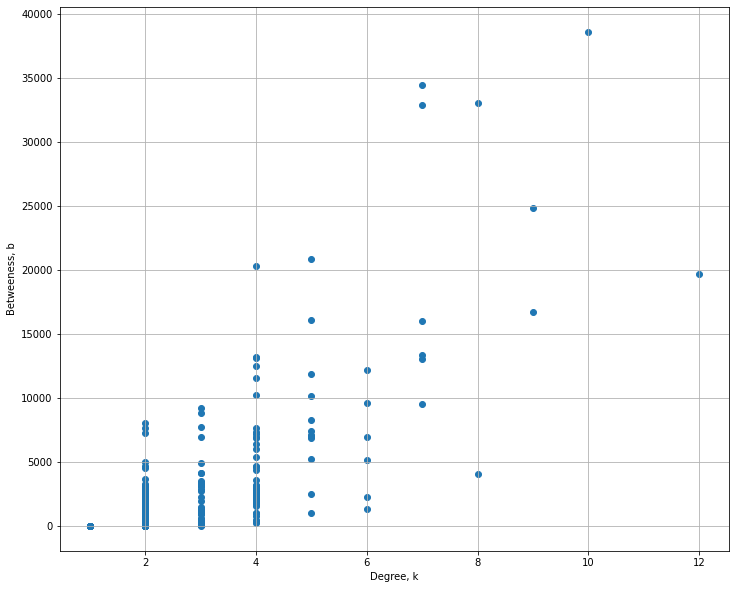

In [9]:
f, ax = plt.subplots(figsize=(12, 10))

ax.scatter(node_degree, node_betweeness)
ax.set_xlabel("Degree, k")
ax.set_ylabel("Betweeness, b")
ax.grid(which="major")

In [10]:
COLOR2BOROUGH = {
    "Orange": "Q",
    "Crimson": "M",
    "Steel Blue": "Bk",
    "Web Green": "Bx",
    "Light Cyan": "SI"
}

node_borough = [COLOR2BOROUGH[color] for color in nyc.vs["color"]]

In [11]:
edge_df = nyc.get_edge_dataframe()
edge_df["source_borough"] = edge_df["source"].apply(lambda x: node_borough[x])
edge_df["target_borough"] = edge_df["target"].apply(lambda x: node_borough[x])
edge_df

,source,target,trains,source_borough,target_borough
edge ID,,,,,
0,0,1,2652.0,Q,Q
1,1,2,2652.0,Q,Q
2,2,3,2652.0,Q,Q
3,3,4,2652.0,Q,Q
4,4,5,2652.0,Q,Q
...,...,...,...,...,...
559,432,443,2167.0,Bk,M
560,432,444,2167.0,Bk,Bk
561,434,435,5351.0,M,M


In [12]:
community_df = edge_df.groupby(["source", "source_borough", "target_borough"])[["trains"]].sum().reset_index()
community_df["within_borough"] = community_df["source_borough"] == community_df["target_borough"]
community_df

,source,source_borough,target_borough,trains,within_borough
0,0,Q,Q,2652.0,True
1,1,Q,Q,2652.0,True
2,2,Q,Q,2652.0,True
3,3,Q,Q,2652.0,True
4,4,Q,Q,2652.0,True
...,...,...,...,...,...
421,431,M,M,1000.0,True
422,432,Bk,Bk,2167.0,True
423,432,Bk,M,2167.0,False
424,434,M,M,11239.0,True


Calculate the Within-module degree or *z-score*

In [13]:
communities = community_df["source_borough"].unique().tolist()

z_scores = []
for community in communities:
    df = community_df.query(f"source_borough=='{community}'")
    df = df.query("within_borough==True")
    k_si = df["trains"].mean()
    sigma_si = df["trains"].std()
    df["z_score"] = (df["trains"] - k_si) / sigma_si
    z_scores.append(df[["source", "z_score"]])

z_score_df = pd.concat(z_scores)
z_score_df["z_score"].describe()

count    3.980000e+02
mean     1.115802e-17
std      9.949495e-01
min     -1.500581e+00
25%     -6.527362e-01
50%     -3.817700e-01
75%      3.964363e-01
max      5.671969e+00
Name: z_score, dtype: float64

Calculate the participation coefficient

In [14]:
total_degree = community_df.groupby(["source"])["trains"].sum().rename("total_degree").reset_index()

participation_df = community_df.merge(total_degree, on="source")
participation_df["participation"] = (participation_df["trains"] / participation_df["total_degree"]) ** 2
participation_df = participation_df.groupby(["source"])["participation"].sum().reset_index()
participation_df["participation"] = 1 - participation_df["participation"]
participation_df["participation"].describe()

count    410.000000
mean       0.015163
std        0.082211
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: participation, dtype: float64

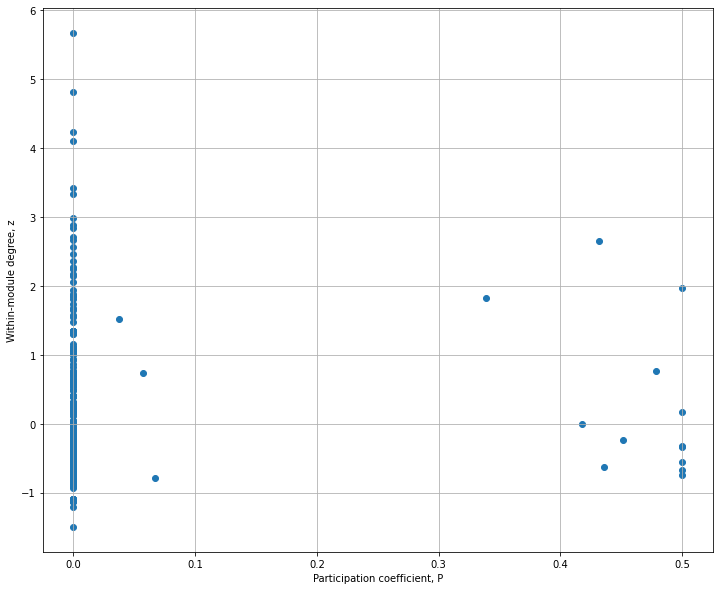

In [15]:
scores = z_score_df.merge(participation_df, on="source")

f, ax = plt.subplots(figsize=(12, 10))
ax.scatter(scores["participation"], scores["z_score"])
ax.set_xlabel("Participation coefficient, P")
ax.set_ylabel("Within-module degree, z")
ax.grid(which="major")

In [16]:
most_central = scores.query("participation > 0.3 & z_score < 3")
most_central = most_central.merge(nyc.get_vertex_dataframe()[["displayname"]], left_on="source", right_index=True)
most_central["most_central"] = True
most_central

,source,z_score,participation,displayname,most_central
31,179,-0.329249,0.500000,21 St-Queensbridge,True
50,224,1.817974,0.338797,Queens Plaza,True
53,230,-0.668631,0.500000,21 St,True
67,385,0.762850,0.478686,Queensboro Plaza,True
109,185,-0.621964,0.436218,Grand St,True
111,187,-0.737433,0.500000,East Broadway,True
144,273,-0.332413,0.500000,Wall St,True
161,363,-0.238045,0.451554,135 St,True
177,15,2.651808,0.432067,DeKalb Av,True
253,135,0.170714,0.500000,High St,True


In [23]:
properties_df = scores.merge(most_central[["source", "most_central"]], how="left", on="source")
properties_df["most_central"] = properties_df["most_central"].fillna(False)
properties_df = nyc.get_vertex_dataframe().merge(properties_df[["source", "participation", "z_score", "most_central"]], how="left", left_on="vertex ID", right_on="source")
nyc.vs["participation"] = properties_df["participation"]
nyc.vs["z_score"] = properties_df["z_score"]

KeyError: 'participation'

In [18]:
nyc.write("../data/nyc_subway_most_central.gml")